# CoT with Claude


In [ ]:
# Mars Crater vs Volcanic Depression Classification using CNN
# Mount Google Drive and implement complete pipeline

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Mount Google Drive
print("Mounting Google Drive...")
drive.mount('/content/drive')

Mounting Google Drive...
Mounted at /content/drive


In [ ]:

# Define paths
base_path = '/content/drive/MyDrive/Dissertation/FinalDataset'
train_path = os.path.join(base_path, 'train')
val_path = os.path.join(base_path, 'val')
test_path = os.path.join(base_path, 'test')

# Verify paths exist
for path_name, path in [('Train', train_path), ('Validation', val_path), ('Test', test_path)]:
    if os.path.exists(path):
        print(f"✓ {path_name} path exists: {path}")
        # List subdirectories
        subdirs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
        print(f"  Subdirectories: {subdirs}")
    else:
        print(f"✗ {path_name} path not found: {path}")


✓ Train path exists: /content/drive/MyDrive/Dissertation/FinalDataset/train
  Subdirectories: ['Impact', 'Volcanic']
✓ Validation path exists: /content/drive/MyDrive/Dissertation/FinalDataset/val
  Subdirectories: ['Impact', 'Volcanic']
✓ Test path exists: /content/drive/MyDrive/Dissertation/FinalDataset/test
  Subdirectories: ['Impact', 'Volcanic']


In [ ]:

# Image parameters
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32
EPOCHS = 30

# Data generators with augmentation for training
print("\nSetting up data generators...")

# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalize pixel values to [0,1]
    rotation_range=20,           # Rotate images up to 20 degrees
    width_shift_range=0.1,       # Shift width by up to 10%
    height_shift_range=0.1,      # Shift height by up to 10%
    shear_range=0.1,            # Shear transformation
    zoom_range=0.1,             # Zoom in/out by up to 10%
    horizontal_flip=True,        # Random horizontal flip
    vertical_flip=True,          # Random vertical flip (valid for Mars surface)
    fill_mode='nearest'          # Fill strategy for new pixels
)

# Validation and test data generators (only rescaling)
val_test_datagen = ImageDataGenerator(rescale=1./255)



Setting up data generators...


In [ ]:

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',         # Binary classification (Impact=0, Volcanic=1)
    color_mode='grayscale',      # Load as grayscale
    shuffle=True,
    seed=42
)

validation_generator = val_test_datagen.flow_from_directory(
    val_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False,
    seed=42
)

test_generator = val_test_datagen.flow_from_directory(
    test_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False,
    seed=42
)

# Print class indices
print(f"\nClass indices: {train_generator.class_indices}")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")


Found 2400 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Found 300 images belonging to 2 classes.

Class indices: {'Impact': 0, 'Volcanic': 1}
Training samples: 2400
Validation samples: 300
Test samples: 300



Displaying sample images...


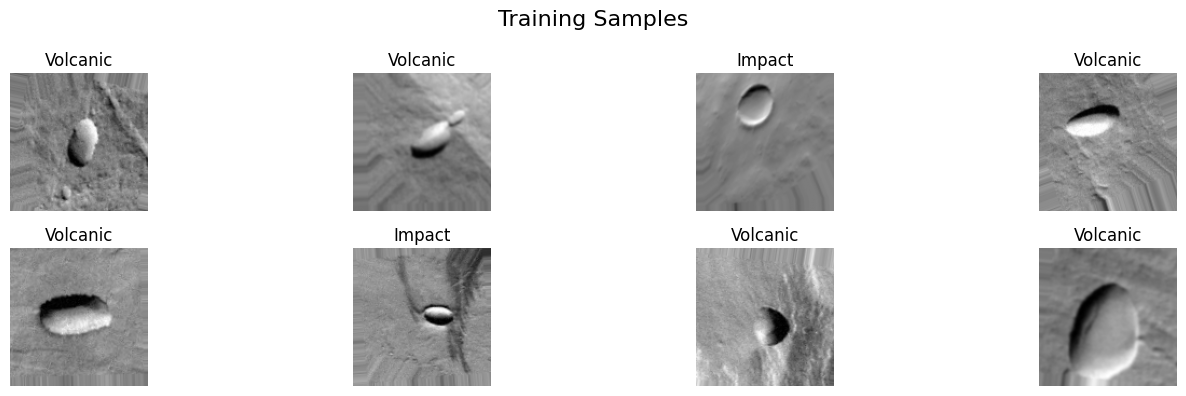

In [ ]:

# Display sample images
def plot_sample_images(generator, title, num_images=8):
    """Plot sample images from generator"""
    plt.figure(figsize=(15, 4))
    plt.suptitle(title, fontsize=16)

    # Get a batch of images
    images, labels = next(generator)

    for i in range(min(num_images, len(images))):
        plt.subplot(2, 4, i+1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        class_name = 'Volcanic' if labels[i] == 1 else 'Impact'
        plt.title(f'{class_name}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Plot sample images
print("\nDisplaying sample images...")
plot_sample_images(train_generator, "Training Samples")

In [ ]:

# Build CNN model
def create_cnn_model():
    """
    Create CNN model optimized for distinguishing circular impact craters
    from elliptical volcanic depressions
    """
    model = keras.Sequential([
        # First convolutional block - detect basic edges and shapes
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Second convolutional block - detect more complex patterns
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Third convolutional block - detect shape-specific features
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Fourth convolutional block - high-level feature detection
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Flatten and dense layers
        layers.Flatten(),
        layers.Dropout(0.5),          # Prevent overfitting
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),

        # Output layer for binary classification
        layers.Dense(1, activation='sigmoid')
    ])

    return model

# Create and compile model
print("\nBuilding CNN model...")
model = create_cnn_model()

# Compile model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Display model architecture
print("\nModel Architecture:")
model.summary()


Building CNN model...

Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,176,705 (19.75 MB)

 Trainable params: 5,174,721 (19.74 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [ ]:

# Calculate total parameters
total_params = model.count_params()
print(f"\nTotal trainable parameters: {total_params:,}")

# Setup callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        '/content/drive/MyDrive/best_mars_crater_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=8,
        min_lr=1e-7,
        verbose=1
    )
]

# Train the model
print("\nStarting training...")
print("Impact craters: circular with raised rims")
print("Volcanic depressions: flatter, more elliptical")
print("CNN will learn to distinguish these spatial features\n")

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)



Total trainable parameters: 5,176,705

Starting training...
Impact craters: circular with raised rims
Volcanic depressions: flatter, more elliptical
CNN will learn to distinguish these spatial features

Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6188 - loss: 0.8579 - precision: 0.6030 - recall: 0.6774
Epoch 1: val_accuracy improved from -inf to 0.52083, saving model to /content/drive/MyDrive/best_mars_crater_model.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 404s 5s/step - accuracy: 0.6192 - loss: 0.8565 - precision: 0.6036 - recall: 0.6774 - val_accuracy: 0.5208 - val_loss: 0.9962 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.7490 - loss: 0.5552 - precision: 0.7255 - recall: 0.7897
Epoch 2: val_accuracy did not improve from 0.52083
75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 188ms/step - accuracy: 0.7491 - loss: 0.5552 - precision: 0.7257 - recall: 0.7897 - val_accuracy: 0.5208 - val_loss: 1.6901 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.7508 - loss: 0.5300 - precision: 0.7285 - recall: 0.7790
Epoch 3: val_accuracy improved from 0.52083 to 0.54861, saving model to /content/drive/MyDrive/best_mars_crater_model.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 295ms/step - accuracy: 0.7511 - loss: 0.5295 - precision: 0.7289 - recall: 0.7792 - val_accuracy: 0.5486 - val_loss: 0.6889 - val_precision: 0.5247 - val_recall: 0.6159 - learning_rate: 0.0010
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.8272 - loss: 0.4118 - precision: 0.8110 - recall: 0.8502
Epoch 4: val_accuracy did not improve from 0.54861
75/75 ━━━━━━━━━━━━━━━━━━━━ 32s 170ms/step - accuracy: 0.8271 - loss: 0.4120 - precision: 0.8110 - recall: 0.8502 - val_accuracy: 0.5486 - val_loss: 0.7138 - val_precision: 0.5230 - val_recall: 0.6594 - learning_rate: 0.0010
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.8391 - loss: 0.3599 - precision: 0.8210 - recall: 0.8718
Epoch 5: val_accuracy did not improve from 0.54861
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 168ms/step - accuracy: 0.8393 - loss: 0.3597 - precision: 0.8211 - recall: 0.8719 - val_accuracy: 0.4792 - val_loss: 1.2495 - val_precision: 0.4792 - val_recall: 1.0000 - le

75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 189ms/step - accuracy: 0.9107 - loss: 0.2284 - precision: 0.8940 - recall: 0.9343 - val_accuracy: 0.7743 - val_loss: 0.4245 - val_precision: 0.6798 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 9/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.9136 - loss: 0.2213 - precision: 0.8934 - recall: 0.9376
Epoch 9: val_accuracy did not improve from 0.77431
75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 184ms/step - accuracy: 0.9136 - loss: 0.2215 - precision: 0.8934 - recall: 0.9375 - val_accuracy: 0.7118 - val_loss: 0.6778 - val_precision: 0.6244 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 10/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9205 - loss: 0.2169 - precision: 0.9011 - recall: 0.9458
Epoch 10: val_accuracy improved from 0.77431 to 0.81250, saving model to /content/drive/MyDrive/best_mars_crater_model.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 188ms/step - accuracy: 0.9204 - loss: 0.2170 - precision: 0.9010 - recall: 0.9457 - val_accuracy: 0.8125 - val_loss: 0.3890 - val_precision: 0.7188 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 11/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9256 - loss: 0.1861 - precision: 0.9011 - recall: 0.9539
Epoch 11: val_accuracy improved from 0.81250 to 0.87500, saving model to /content/drive/MyDrive/best_mars_crater_model.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 465ms/step - accuracy: 0.9255 - loss: 0.1863 - precision: 0.9011 - recall: 0.9538 - val_accuracy: 0.8750 - val_loss: 0.2689 - val_precision: 0.7965 - val_recall: 0.9928 - learning_rate: 0.0010
Epoch 12/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.9240 - loss: 0.1928 - precision: 0.9118 - recall: 0.9427
Epoch 12: val_accuracy did not improve from 0.87500
75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 187ms/step - accuracy: 0.9239 - loss: 0.1930 - precision: 0.9117 - recall: 0.9427 - val_accuracy: 0.6493 - val_loss: 1.3196 - val_precision: 0.9512 - val_recall: 0.2826 - learning_rate: 0.0010
Epoch 13/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9058 - loss: 0.2090 - precision: 0.8883 - recall: 0.9291
Epoch 13: val_accuracy improved from 0.87500 to 0.90972, saving model to /content/drive/MyDrive/best_mars_crater_model.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 188ms/step - accuracy: 0.9058 - loss: 0.2091 - precision: 0.8883 - recall: 0.9291 - val_accuracy: 0.9097 - val_loss: 0.2355 - val_precision: 0.8944 - val_recall: 0.9203 - learning_rate: 0.0010
Epoch 14/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.9286 - loss: 0.1927 - precision: 0.9097 - recall: 0.9522
Epoch 14: val_accuracy improved from 0.90972 to 0.94792, saving model to /content/drive/MyDrive/best_mars_crater_model.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 468ms/step - accuracy: 0.9285 - loss: 0.1928 - precision: 0.9097 - recall: 0.9520 - val_accuracy: 0.9479 - val_loss: 0.1648 - val_precision: 0.9843 - val_recall: 0.9058 - learning_rate: 0.0010
Epoch 15/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.9367 - loss: 0.1717 - precision: 0.9221 - recall: 0.9532
Epoch 15: val_accuracy did not improve from 0.94792
75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 184ms/step - accuracy: 0.9366 - loss: 0.1719 - precision: 0.9220 - recall: 0.9532 - val_accuracy: 0.9340 - val_loss: 0.1623 - val_precision: 0.8790 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 16/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9377 - loss: 0.1656 - precision: 0.9211 - recall: 0.9552
Epoch 16: val_accuracy improved from 0.94792 to 0.95139, saving model to /content/drive/MyDrive/best_mars_crater_model.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 188ms/step - accuracy: 0.9376 - loss: 0.1659 - precision: 0.9211 - recall: 0.9550 - val_accuracy: 0.9514 - val_loss: 0.1324 - val_precision: 0.9627 - val_recall: 0.9348 - learning_rate: 0.0010
Epoch 17/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.9520 - loss: 0.1486 - precision: 0.9349 - recall: 0.9700
Epoch 17: val_accuracy improved from 0.95139 to 0.95486, saving model to /content/drive/MyDrive/best_mars_crater_model.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 206ms/step - accuracy: 0.9519 - loss: 0.1489 - precision: 0.9349 - recall: 0.9698 - val_accuracy: 0.9549 - val_loss: 0.1164 - val_precision: 0.9496 - val_recall: 0.9565 - learning_rate: 0.0010
Epoch 18/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.9399 - loss: 0.1649 - precision: 0.9163 - recall: 0.9643
Epoch 18: val_accuracy did not improve from 0.95486
75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 186ms/step - accuracy: 0.9398 - loss: 0.1650 - precision: 0.9164 - recall: 0.9642 - val_accuracy: 0.9236 - val_loss: 0.2230 - val_precision: 0.9328 - val_recall: 0.9058 - learning_rate: 0.0010
Epoch 19/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9465 - loss: 0.1557 - precision: 0.9288 - recall: 0.9649
Epoch 19: val_accuracy did not improve from 0.95486
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 173ms/step - accuracy: 0.9465 - loss: 0.1556 - precision: 0.9290 - recall: 0.9648 - val_accuracy: 0.9375 - val_loss: 0.1727 - val_precision: 0.9167 - val_recall: 0.9565 

75/75 ━━━━━━━━━━━━━━━━━━━━ 15s 196ms/step - accuracy: 0.9442 - loss: 0.1423 - precision: 0.9295 - recall: 0.9596 - val_accuracy: 0.9688 - val_loss: 0.0799 - val_precision: 0.9510 - val_recall: 0.9855 - learning_rate: 0.0010
Epoch 26/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9549 - loss: 0.1289 - precision: 0.9387 - recall: 0.9724
Epoch 26: val_accuracy improved from 0.96875 to 0.97222, saving model to /content/drive/MyDrive/best_mars_crater_model.h5


75/75 ━━━━━━━━━━━━━━━━━━━━ 22s 216ms/step - accuracy: 0.9549 - loss: 0.1290 - precision: 0.9387 - recall: 0.9723 - val_accuracy: 0.9722 - val_loss: 0.0953 - val_precision: 0.9710 - val_recall: 0.9710 - learning_rate: 0.0010
Epoch 27/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.9530 - loss: 0.1362 - precision: 0.9383 - recall: 0.9703
Epoch 27: val_accuracy did not improve from 0.97222
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 248ms/step - accuracy: 0.9531 - loss: 0.1360 - precision: 0.9384 - recall: 0.9703 - val_accuracy: 0.9653 - val_loss: 0.0947 - val_precision: 0.9776 - val_recall: 0.9493 - learning_rate: 0.0010
Epoch 28/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9576 - loss: 0.1116 - precision: 0.9463 - recall: 0.9743
Epoch 28: val_accuracy did not improve from 0.97222
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 167ms/step - accuracy: 0.9575 - loss: 0.1117 - precision: 0.9463 - recall: 0.9742 - val_accuracy: 0.9236 - val_loss: 0.1907 - val_precision: 0.9754 - val_recall: 0.8623 

# Analysis

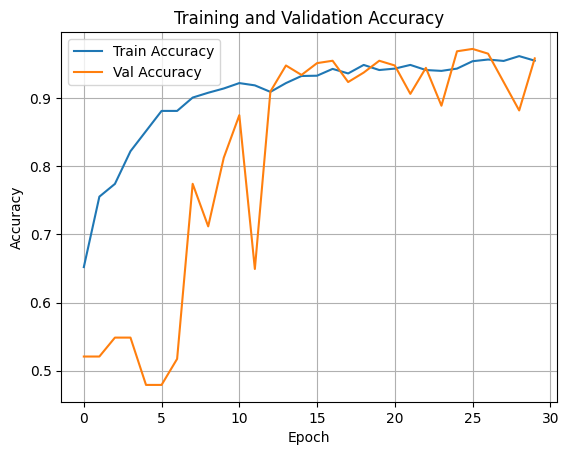

In [ ]:
import matplotlib.pyplot as plt


plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.grid(True)
plt.show()

In [ ]:
val_loss, val_acc = model.evaluate(val_generator)
test_loss, test_acc = model.evaluate(test_generator)

print(f'Validation Accuracy: {val_acc:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')

NameError: name 'val_generator' is not defined

10/10 ━━━━━━━━━━━━━━━━━━━━ 55s 6s/step
              precision    recall  f1-score   support

      Impact       0.98      0.92      0.95       150
    Volcanic       0.92      0.98      0.95       150

    accuracy                           0.95       300
   macro avg       0.95      0.95      0.95       300
weighted avg       0.95      0.95      0.95       300



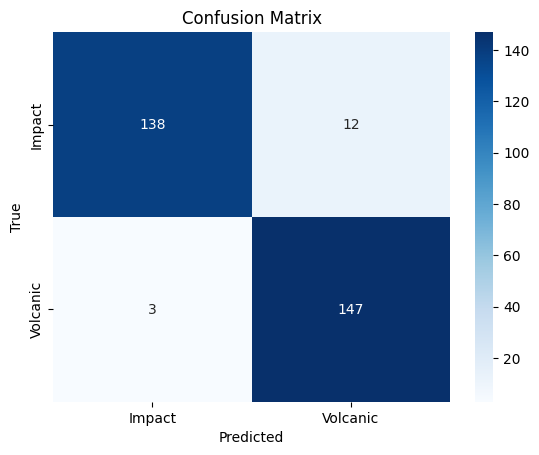

In [ ]:
from sklearn.metrics import (classification_report, confusion_matrix)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

y_probs = model.predict(test_generator).ravel()
y_pred = (y_probs > 0.5).astype(int)
y_true = test_generator.classes

print(classification_report(y_true, y_pred, target_names=['Impact', 'Volcanic']))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Impact', 'Volcanic'], yticklabels=['Impact', 'Volcanic'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Save

In [ ]:
# Create folder if it doesn't exist
import os
save_dir = "/content/drive/MyDrive/Dissertation/Models"
os.makedirs(save_dir, exist_ok=True)

# Save model
model.save(os.path.join(save_dir, "EXP_006.h5"))
print(f"Model saved to {os.path.join(save_dir, 'EXP_006.h5')}")

import pickle

# Save history object
with open(os.path.join(save_dir, "EXP_006_history.pkl"), "wb") as f:
    pickle.dump(history.history, f)

print(f"History saved to {os.path.join(save_dir, 'EXP_006_history.pkl')}")


Model saved to /content/drive/MyDrive/Dissertation/Models/EXP_006.h5
History saved to /content/drive/MyDrive/Dissertation/Models/EXP_006_history.pkl
